In [1]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 15.4 MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import math 
from __future__ import print_function
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import io
import os
from google.colab import files
import numpy as np
import torch
import pydicom as dicom
import pywt
import cv2
import matplotlib.pylab as plt
tf.compat.v1.disable_v2_behavior
tf.compat.v1.disable_eager_execution()

In [3]:
print(tf.__version__)

2.8.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
train_dir = os.path.join('/content/drive/MyDrive/ADNI_pictures/', 'train_dataset/')
test_dir =  os.path.join('/content/drive/MyDrive/ADNI_pictures/', 'test_dataset/')

In [20]:
num_tr = len(os.listdir(train_dir))
num_tst = len(os.listdir(test_dir))

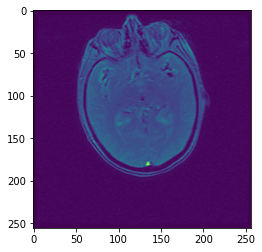

In [21]:
import cv2
def dicom_dwt_transform(dir):
  dwt_data = []
  for filename in os.listdir(dir):
    image_path = dir + filename
    if ".dcm" in filename.lower():
      ds = dicom.dcmread(dir + filename)
      # Wavelet transform of image, and plot approximation and details
      coeffs_1 = pywt.dwt2(ds.pixel_array, 'haar')
      cA1, (cH2, cV2, cD2) = coeffs_1
      coeffs_2 = pywt.dwt2(cA1, 'haar')
      cA2, (cH2, cV2, cD2) = coeffs_2
      dwt_data.append(ds.pixel_array) #Without haar transform
  return dwt_data
  
training_data = dicom_dwt_transform(train_dir)
training_data = np.array(training_data)
test_data = dicom_dwt_transform(test_dir)
test_data = np.array(test_data)
plt.imshow(training_data[0])
plt.imshow(test_data[0])

Making Label Arrays

In [22]:
entire_array = []

for j in range(160):
  batch_5 = []
  q = 5*j
  for i in range(5):
    batch_5.append(training_data[q])
    q+=1
  entire_array.append(batch_5)
entire_array = np.array(entire_array)

In [23]:
entire_array_test = []
for j in range(40):
  batch_5_test = []
  a = 5*j
  for i in range(5):    
    batch_5_test.append(test_data[a])
    a+=1
  entire_array_test.append(batch_5_test)
entire_array_test = np.array(entire_array_test)

In [24]:
##CREATE TRAINING LABEL ARRAY
label_ad = np.full((82,2), [1, 0], dtype = int)

label_cn = np.full((82,2), [0, 1], dtype = int)

label_all = np.concatenate([label_ad, label_cn])

##RANDOMIZE TRAINING DATA AND LABELS TOGETHER
random_training_data = entire_array
print("entire array:", entire_array.shape)
#random_training_data = tf.convert_to_tensor(random_training_data)
random_labels = label_all

##FIND AND SHUFFLE INDICES
indices = tf.range(start=0, limit=tf.shape(random_training_data)[0], dtype=tf.int32)
ind_shuf = (tf.random.shuffle(indices)).eval(session=tf.compat.v1.Session())

#
random_training_data = tf.gather(random_training_data, ind_shuf)
#random_training_data = [entire_array[i] for i in ind_shuf]
#np.take_along_axis(random_training_data, ind_shuf, axis = 1)
training_data_ad_train = random_training_data.eval(session=tf.compat.v1.Session())    #####TAKE OUT EVAL  


#random_labels = tf.gather(random_labels, ind_shuf)
random_labels = [label_all[i] for i in ind_shuf]
#print("label all shape: ", label_all.shape)

#print(training_data_ad.eval(session=tf.compat.v1.Session()))

#training_data_ad = tf.compat.v1.convert_to_tensor(training_data_ad, dtype = object)
#training_data_ad = np.array(training_data_ad)
#training_data_ad = tf.ragged.constant(training_data_ad)




##TESTING DATA RANDOMIZING
label_ad_test = np.full((20,2), [1, 0], dtype = int)

label_cn_test = np.full((20,2), [0, 1], dtype = int)

label_all_test = np.concatenate([label_ad_test, label_cn_test])
#print("test labels shape: ", label_all_test.shape)


random_training_data_test = entire_array_test

random_labels = label_all_test

indices = tf.range(start=0, limit=tf.shape(random_training_data_test)[0], dtype=tf.int32)
ind_shuf = tf.random.shuffle(indices)
#ind_shuf = ind_shuf.eval(session=tf.compat.v1.Session())

random_training_data_test = tf.gather(random_training_data_test, ind_shuf)

training_data_test = random_training_data_test
#print("test array shape: ", random_training_data_test.shape)
#training_data_test = torch.FloatTensor(training_data_test)
random_labels = tf.gather(random_labels, ind_shuf)

label_all_test = random_labels

entire array: (160, 5, 256, 256)


In [25]:

##CREATE TRAINING LABEL ARRAY
label_ad = np.full((383,2), [1, 0], dtype = int)

label_cn = np.full((425,2), [0, 1], dtype = int)
label_all = np.concatenate([label_ad, label_cn])

In [26]:
##TESTING DATA RANDOMIZING
label_ad_test = np.full((101,2), [1, 0], dtype = int)

label_cn_test = np.full((102,2), [0, 1], dtype = int)

label_all_test = np.concatenate([label_ad_test, label_cn_test])

Initialization

In [27]:
ad_size = 383 # number of images in ad training set
cn_size = 424 # number of images in the cn training set
img_height = 250
img_width = 250
init = tf.compat.v1.global_variables_initializer()

Hyperparameters – training iterations, learning rate, and batch size

In [28]:
training_iterations = 10 # number of times we train the network
learning_rate = 0.001 # factor that is multiplied with the weights based on which weights get updated
batch_size = 5 # number of images in each batch that will be trained at a time (power of 2)

Categorical class labels

In [29]:
label_dict = {0: 'Alzheimer', 1: 'Cognitively Normal'} 

Shape of Training Set

In [30]:
print("All training data shape: ", training_data.shape) # getting shape of the AD data
print("Test training data shape: ", test_data.shape) # getting shape of the CN data

All training data shape:  (808, 256, 256)
Test training data shape:  (203, 256, 256)


Reshaping

In [32]:
training_data_ad = tf.reshape(training_data, [-1, 256, 256, 1])
training_data_test = tf.reshape(test_data, [-1, 256, 256, 1])

In [33]:
print("AD training data shape: ", training_data_ad.shape) # getting shape of the AD data
print("CN training data shape: ", training_data_test.shape) # getting shape of the CN data

AD training data shape:  (808, 256, 256, 1)
CN training data shape:  (203, 256, 256, 1)


Network Parameters

In [34]:
n_input = 22 # size of the input
n_classes = 2 # AD vs CN

Placeholders

In [35]:
x = tf.compat.v1.placeholder("float", [5, 256, 256, 1])
y = tf.compat.v1.placeholder("float", [None,n_classes])

In [36]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [37]:
batch_size = 10
epochs = 10

In [38]:
detector_model = Sequential()
detector_model.add(Conv2D(32, 3, 3, name='conv1', input_shape=(256,256,1), padding='same'))
detector_model.add(MaxPooling2D(pool_size=(2,2), name='pool1'))

detector_model.add(Conv2D(64, 3, 3, name='conv2', padding='same'))
detector_model.add(MaxPooling2D(pool_size=(2,2), name='pool2'))

detector_model.add(Conv2D(128, 3, 3, name='conv3', padding='same'))
detector_model.add(MaxPooling2D(pool_size=(2,2), name='pool3', padding='same'))
detector_model.add(Flatten())
detector_model.add(Dense(2000, activation='relu', name='dense1'))
detector_model.add(Dropout(0.5, name='dropout1'))

detector_model.add(Dense(500, activation='relu', name='dense2'))
detector_model.add(Dropout(0.5, name='dropout2'))

detector_model.add(Dense(n_classes, activation='sigmoid', name='sigmoid'))


"\ndetector_model = Sequential()\ndetector_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(64,64,1),padding='same'))\ndetector_model.add(LeakyReLU(alpha=0.1))\ndetector_model.add(MaxPooling2D((2, 2),padding='same'))\ndetector_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))\ndetector_model.add(LeakyReLU(alpha=0.1))\ndetector_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))\ndetector_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))\ndetector_model.add(LeakyReLU(alpha=0.1))                  \ndetector_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))\ndetector_model.add(Flatten())\ndetector_model.add(Dense(128, activation='linear'))\ndetector_model.add(LeakyReLU(alpha=0.1))                  \ndetector_model.add(Dense(n_classes, activation='sigmoid'))\n"

In [39]:
detector_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
detector_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 86, 86, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 43, 43, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 15, 15, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 7, 7, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0

In [40]:
detector_train = detector_model.fit(training_data_ad, label_all,  batch_size=batch_size,epochs=epochs,verbose=1, steps_per_epoch = 15, validation_data=(training_data_test, label_all_test), validation_steps = 15, shuffle = True)

Train on 15 samples, validate on 203 samples
Epoch 1/10
15/15 [==============================] - ETA: 0s - batch: 7.0000 - size: 1.0000 - loss: 8.5058 - accuracy: 0.5148

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


15/15 [==============================] - 58s 4s/step - batch: 7.0000 - size: 1.0000 - loss: 8.5058 - accuracy: 0.5148 - val_loss: 0.8806 - val_accuracy: 0.5025
Epoch 2/10
15/15 [==============================] - 52s 3s/step - batch: 7.0000 - size: 1.0000 - loss: 0.7686 - accuracy: 0.5633 - val_loss: 0.6210 - val_accuracy: 0.6453
Epoch 3/10
15/15 [==============================] - 52s 3s/step - batch: 7.0000 - size: 1.0000 - loss: 0.6246 - accuracy: 0.6395 - val_loss: 0.6135 - val_accuracy: 0.6749
Epoch 4/10
15/15 [==============================] - 52s 4s/step - batch: 7.0000 - size: 1.0000 - loss: 0.5082 - accuracy: 0.7393 - val_loss: 0.6886 - val_accuracy: 0.7488
Epoch 5/10
15/15 [==============================] - 52s 3s/step - batch: 7.0000 - size: 1.0000 - loss: 0.3434 - accuracy: 0.8416 - val_loss: 1.3675 - val_accuracy: 0.8030
Epoch 6/10
15/15 [==============================] - 52s 3s/step - batch: 7.0000 - size: 1.0000 - loss: 0.1754 - accuracy: 0.9351 - val_loss: 2.6871 - val_ac

In [41]:
predictions = detector_model.predict(training_data_test[:200], steps = 1)
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0,

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0
 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


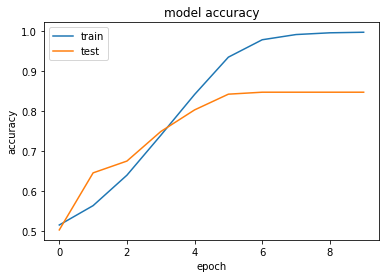

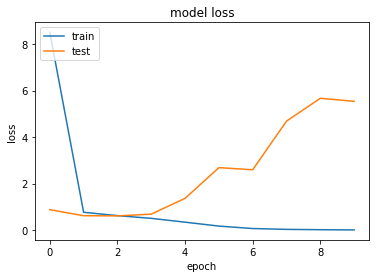

In [44]:
#graph results
plt.plot(detector_train.history['accuracy'])
plt.plot(detector_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(detector_train.history['loss'])
plt.plot(detector_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Wrappers

In [ ]:
print(training_data_test.shape)
print(label_all.shape)


(200, 64, 64, 1)
(164, 2)
